# Spark Setup

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.3.4/spark-2.3.4-bin-hadoop2.7.tgz
!tar xf spark-2.3.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.4-bin-hadoop2.7"

import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.master('local[*]').appName('test').getOrCreate()

from pyspark import SparkConf
SparkConf().set("spark.executor.memory", "13g")

In [3]:
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.ml.feature import Bucketizer 

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
import matplotlib
import pandas as pd
import numpy as np
import zipfile
from google.colab import files


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# Run this cell and select the kaggle.json file downloaded from the Kaggle account settings page.
files.upload()
# Install the Kaggle API client/.
!pip install -q kaggle
# The Kaggle API client expects this file to be in ~/.kaggle so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Avoid Warnings
!chmod 600 ~/.kaggle/kaggle.json
#  Copy API command from kaggle and paste it to download desired dataset
!kaggle datasets download -d ntnu-testimon/paysim1
# open and extract files 
zip_ref = zipfile.ZipFile('paysim1.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()
# list the files present in zip
!ls files

Saving kaggle.json to kaggle.json
 98% 175M/178M [00:02<00:00, 63.5MB/s]
100% 178M/178M [00:02<00:00, 68.2MB/s]
PS_20174392719_1491204439457_log.csv


In [5]:
# Read data to spark dataframe
# set inferSchema = True, to get the input schema automatically from data.
df = spark.read.csv('/content/files/PS_20174392719_1491204439457_log.csv', header=True, inferSchema = True)
# columnar storage of data for efficient complex data processing.
# df.repartition(1).write.partitionBy('type').mode("overwrite").parquet("data/df.parquet")
# df = spark.read.option("mergeSchema", "true").parquet("data/df.parquet")

## Time Step Features

In [6]:
df = df.withColumn('day_of_month', F.when( (F.col('step')%24) !=0, ( ( F.col('step')/24) +1)).otherwise(( F.col('step')/24)).cast(T.IntegerType()))
df = df.withColumn('hour_of_day',F.when((F.col('step')%24)!=0,  (F.col('step')%24)).otherwise(24).cast(T.IntegerType()))
df = df.withColumn('day_of_week',F.when((F.col('day_of_month')%7)!=0,(F.col('day_of_month')%7)).otherwise(7.0))
df = df.withColumn('week_of_month',F.when( (F.col('day_of_month')%7) !=0, ( ( F.col('day_of_month')/7) +1)).otherwise( F.col('day_of_month')/7).cast(T.IntegerType()))

In [7]:
df_final = df.filter(F.col('type').isin(['TRANSFER','CASH_OUT']))

In [8]:
df_final = df_final.withColumn('TRANSFER',F.when(F.col('type')=='TRANSFER',1).otherwise(0))
df_final = df_final.withColumn('CASH_OUT',F.when(F.col('type')=='CASH_OUT',1).otherwise(0))


Split Amount in 93 Buckets, each of one million.

In [9]:
bucketizer = Bucketizer(splits=list(range(0,100000000,1000000)),inputCol='amount', outputCol= "amount_bucket")
df_final = bucketizer.transform(df_final)
df_final = df_final.withColumn('amount_bucket',F.col('amount_bucket')+1)

In [10]:
df_final = df_final.drop(*['nameOrig', 'nameDest','isFlaggedFraud','type','day_of_month', 'day_of_week', 'week_of_month'])

In [11]:
df_final.columns

['step',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'hour_of_day',
 'TRANSFER',
 'CASH_OUT',
 'amount_bucket']

In [12]:
df_final = df_final.sort('step')

In [13]:
# df_final.show()

In [14]:
X = df_final.drop('isFraud')
Y = df_final.select('isFraud')

# Modeling

In [93]:
# Importing Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,confusion_matrix
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import seaborn as sns

In [94]:
# Conversion to Pandas DataFrame
Xpd=X.toPandas()
Ypd=Y.toPandas()

## Weighted Neural Network With Keras

Reshaping and Normalizing

In [95]:
# Reshaping
Ypd=Ypd.values.reshape(-1,1)

# Normalizing
st_sc = StandardScaler()
Xpd = st_sc.fit_transform(Xpd)

In [96]:
# ohe=OneHotEncoder()
# Ypd=ohe.fit_transform(Ypd).toarray()

Train Test Split

In [97]:
# spliting
x_train, x_test, y_train,y_test=train_test_split(Xpd,Ypd, test_size=0.2, random_state=1)

Modeling

In [98]:
# Heuristic based class weighing, inverting ratio of the class distribution and taking squareroot
weights = {0:1, 1:np.sqrt(336)}

In [99]:
# Function for model creation
def create_model(optimizer = "adam", dropout_rate=0.0, init_mode='uniform', activation='relu'):
  model = Sequential()
  model.add(Dense(units = 64, input_dim = 10, activation = activation, kernel_initializer=init_mode))
  model.add(Dense(units = 32, activation = activation))
  model.add(Dropout(dropout_rate))
  model.add(Dense(units = 1, activation = "sigmoid"))
  model.compile(optimizer = optimizer, loss = "binary_crossentropy", metrics = ["accuracy"])
  return model

In [100]:
# Wrapping keras model
model = KerasClassifier(build_fn=create_model, verbose=1)

In [101]:
# define the grid search parameters
batch_size = [20000, 200000]
optimizer = ['SGD', 'RMSprop', 'Adam', 'Adagrad']
init_mode = ['uniform', 'glorot_uniform', 'he_uniform']
activation = ['relu', 'tanh', 'sigmoid']
epochs = [5, 10]
dropout_rate = [0.0, 0.1, 0.2, 0.3]
param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer=optimizer, dropout_rate=dropout_rate, init_mode = init_mode, activation = activation)

In [103]:
# RandomizedSearchCV
Randomized_Search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_jobs=-1)
Randomized_Search_result = Randomized_Search.fit(x_train, y_train, class_weight=weights, validation_split=0.20, verbose=1)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Train on 1773061 samples, validate on 443266 samples
Epoch 1/10
1773061/1773061 [==============================] - 2s 1us/step - loss: 0.2672 - accuracy: 0.9690 - val_loss: 0.1080 - val_accuracy: 0.9965
Epoch 2/10
1773061/1773061 [==============================] - 1s 1us/step - loss: 0.0874 - accuracy: 0.9957 - val_loss: 0.0775 - val_accuracy: 0.9960
Epoch 3/10
1773061/1773061 [==============================] - 1s 1us/step - loss: 0.0662 - accuracy: 0.9958 - val_loss: 0.0584 - val_accuracy: 0.9962
Epoch 4/10
1773061/1773061 [==============================] - 1s 1us/step - loss: 0.0565 - accuracy: 0.9962 - val_loss: 0.0525 - val_accuracy: 0.9974
Epoch 5/10
1773061/1773061 [==============================] - 1s 1us/step - loss: 0.0501 - accuracy: 0.9965 - val_loss: 0.0448 - val_accuracy: 0.9967
Epoch 6/10
1773061/1773061 [==============================] - 1s 1us/step - loss: 0.0443 - accuracy: 0.9967 - val_loss: 0.0411 - val_accuracy: 0.9969
Epoch 7/10
1773061/1773061 [===================

In [ ]:
# GridSearchCV
Grid_Search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
Grid_Search_result = Grid_Search.fit(x_train, y_train, class_weight=weights, validation_split=0.20, verbose=1)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [41]:
# summarize results
print("Randomized_Search_result: \n Best: %f using %s" % (Randomized_Search_result.best_score_, Randomized_Search_result.best_params_))
print("Grid_Search: \nBest: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.968550 using {'optimizer': 'Adam', 'init_mode': 'he_uniform', 'epochs': 10, 'dropout_rate': 0.1, 'batch_size': 20000, 'activation': 'tanh'}


In [87]:
# model with best parameters
model = Sequential()
model.add(Dense(units = 64, input_dim = 10, activation = grid_result.best_params_['activation'], kernel_initializer=grid_result.best_params_['init_mode']))
model.add(Dense(units = 32, activation = grid_result.best_params_['activation']))
model.add(Dropout(grid_result.best_params_['dropout_rate']))
model.add(Dense(units = 1, activation = "sigmoid"))
model.compile(optimizer = grid_result.best_params_['optimizer'], loss = "binary_crossentropy", metrics = ["accuracy"])

In [88]:
weights = {0:1, 1:np.sqrt(336)}
model.fit(x_train, y_train, class_weight=weights, validation_split=0.20, verbose=1, epochs = 10, batch_size = 20000)

Train on 1773061 samples, validate on 443266 samples
Epoch 1/10
1773061/1773061 [==============================] - 2s 1us/step - loss: 0.3326 - accuracy: 0.9121 - val_loss: 0.1242 - val_accuracy: 0.9926
Epoch 2/10
1773061/1773061 [==============================] - 1s 1us/step - loss: 0.0939 - accuracy: 0.9940 - val_loss: 0.0766 - val_accuracy: 0.9954
Epoch 3/10
1773061/1773061 [==============================] - 1s 1us/step - loss: 0.0695 - accuracy: 0.9955 - val_loss: 0.0639 - val_accuracy: 0.9964
Epoch 4/10
1773061/1773061 [==============================] - 1s 1us/step - loss: 0.0592 - accuracy: 0.9961 - val_loss: 0.0563 - val_accuracy: 0.9968
Epoch 5/10
1773061/1773061 [==============================] - 1s 1us/step - loss: 0.0523 - accuracy: 0.9964 - val_loss: 0.0504 - val_accuracy: 0.9969
Epoch 6/10
1773061/1773061 [==============================] - 1s 1us/step - loss: 0.0472 - accuracy: 0.9967 - val_loss: 0.0461 - val_accuracy: 0.9966
Epoch 7/10
1773061/1773061 [===================

In [89]:
# Predicting the Test set results
y_pred = model.predict(x_test)
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0

Test Recall: 0.8421
Test Precision: 0.4902


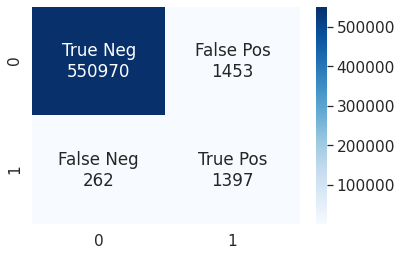

In [90]:
print("Test Recall: %0.4f" % recall_score(y_test, y_pred))
print("Test Precision: %0.4f" % precision_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred) # rows = truth, cols = prediction
# df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
plt.show()